In [1]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from pgmpy.inference import VariableElimination
import warnings
import json
warnings.filterwarnings("ignore")

In [2]:

with open("../../../../data/Weakness.json", 'r+') as weakfile:
    weak = json.load(weakfile)
    weakfile.close()
    
def Generate_Multiplicator(x):
    EnemyType = x["Enemy Type"]
    MoveType = x["Type Move"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    for i in range(len(EnemyType)):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
        elif i == 1:
            EnemyType[1] = EnemyType[1][2:-2]
    for Type in EnemyType:
        if not Type.isalnum():
            continue
        weakness = weakness * weak[MoveType][Type] 
    return weakness

def percentual_Transform(s):
    
    l = s.split("\/")
    l = list(map(lambda n: int(n),l))
    p = (l[0]/l[1] * 100)
    
    return p

def check_stab(df):
    new_col = []
    for i in range(len(df)):
        if df['Pokemon Type'][i].split('\'')[1] == df['Type Move'][i] or (len(df['Pokemon Type'][i].split('\'')) > 3 and df['Pokemon Type'][i].split('\'')[3] == df['Type Move'][i]):
            new_col.append(True)
        else:
            new_col.append(False)
    df = df.assign(stab=new_col)
    df = df.drop(['Pokemon Type', 'Type Move'], axis= 1)
    return df

In [3]:
#load the dataset
df = pd.read_csv("../parsing Dataset/log/Dataset.csv") 

#transform the life of the Pokèmon from absolute value to percentage
df["UserHP"] = df["UserHP"].map(percentual_Transform)
df["SuffererHP"] = df["SuffererHP"].map(percentual_Transform)

#rename of the column to match the node of the network
df.rename({"UserHP": "Pokemon HP","SuffererHP": "Enemy HP","TypeM": "Type Move",
           "categoryMove": "Category","TypesS" : "Enemy Type","TypesU":"Pokemon Type",
           "power":"Power"}, axis=1, inplace=True)

#to reduce the number of node and value, we decide to calculate the multipicator (the "power") of the move with respect to the type of the enemy
df["Multiplicator"] = df[["Enemy Type","Type Move"]].apply(Generate_Multiplicator, axis=1)
#for every move we check if it has the same type of the Pokèmon that use it
df = check_stab(df)

#we adjust some text in the dataset
df["Weather"] = df["Weather"].str.rstrip().str.lower()
df["Status enemy"] = df["Status enemy"].str.rstrip().str.lower()
df["Sufferer"] = df["Sufferer"].str.rstrip().str.lower()
df["User"] = df["User"].str.rstrip().str.lower()

#a Pokèmon can have up to 7 different boost, each with 5 different value, this would cause a massive increase of the complexity, to avoid this, we summed all the bost in a single one
df["Boost"] = df["attack_boost"] + df["defense_boost"] + df["special_attack_boost"] + df["special_defense_boost"] + df["speed_boost"] + df["evasion_boost"] + df["accuracy_boost"]


#we remove the useless column
df = df.drop(["accuracy_boost","speed_boost","evasion_boost",
              "attack_boost","defense_boost","special_attack_boost","special_defense_boost","Enemy Type"],axis=1)

df



,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Status enemy,Choose,Multiplicator,stab,Boost
0,klinklang,klinklang,Substitute,0,100.000000,100.000000,none,status,normal,1.0,1.0,False,0.0
1,hydreigon,klinklang,U-turn,70,100.000000,100.000000,none,physical,normal,1.0,1.0,False,0.0
2,klinklang,emboar,Return,102,100.000000,100.000000,none,physical,normal,1.0,1.0,False,0.0
3,klinklang,emboar,Substitute,0,100.000000,100.000000,none,status,normal,0.0,1.0,False,0.0
4,emboar,klinklang,Fire Blast,110,100.000000,100.000000,none,special,normal,1.0,1.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,persian,persian,Nasty Plot,0,100.000000,100.000000,none,status,par,1.0,1.0,False,0.0
8469,entei,persian,Sacred Fire,100,72.638436,100.000000,none,physical,par,1.0,1.0,True,-2.0
8470,persian,entei,Dark Pulse,80,100.000000,72.638436,none,special,psn,1.0,1.0,False,2.0
8471,persian,entei,Nasty Plot,0,100.000000,100.000000,none,status,psn,0.0,1.0,False,2.0


In [4]:
from sklearn.preprocessing import KBinsDiscretizer

#we reduce the number of differente value for some numeric variable to reduce the complexity of the network
enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
enc.fit(df[["Pokemon HP"]])
df["Pokemon HP"] = enc.transform(df[["Pokemon HP"]]).astype(int)

enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
enc.fit(df[["Enemy HP"]])
df["Enemy HP"] = enc.transform(df[["Enemy HP"]]).astype(int)

enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='kmeans')
enc.fit(df[["Power"]])
df["Power"] = enc.transform(df[["Power"]]).astype(int)

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df[["Boost"]])
df["Boost"] = enc.transform(df[["Boost"]]).astype(int)

'''
enc = KBinsDiscretizer(n_bins=2, encode='ordinal',strategy='kmeans')
enc.fit(df[["attack_boost"]])
df["attack_boost"] = enc.transform(df[["attack_boost"]]).astype(int)

enc = KBinsDiscretizer(n_bins=2, encode='ordinal',strategy='kmeans')
enc.fit(df[["defense_boost"]])
df["defense_boost"] = enc.transform(df[["defense_boost"]]).astype(int)

enc = KBinsDiscretizer(n_bins=2, encode='ordinal',strategy='kmeans')
enc.fit(df[["special_attack_boost"]])
df["special_attack_boost"] = enc.transform(df[["special_attack_boost"]]).astype(int)

enc = KBinsDiscretizer(n_bins=2, encode='ordinal',strategy='kmeans')
enc.fit(df[["special_defense_boost"]])
df["special_defense_boost"] = enc.transform(df[["special_defense_boost"]]).astype(int)

enc = KBinsDiscretizer(n_bins=2, encode='ordinal',strategy='kmeans')
enc.fit(df[["evasion_boost"]])
df["evasion_boost"] = enc.transform(df[["evasion_boost"]]).astype(int)

enc = KBinsDiscretizer(n_bins=2, encode='ordinal',strategy='kmeans')
enc.fit(df[["speed_boost"]])
df["speed_boost"] = enc.transform(df[["speed_boost"]]).astype(int)

enc = KBinsDiscretizer(n_bins=2, encode='ordinal',strategy='kmeans')
enc.fit(df[["accuracy_boost"]])
df["accuracy_boost"] = enc.transform(df[["accuracy_boost"]]).astype(int)

df = df.drop(["accuracy_boost","speed_boost","evasion_boost"],axis=1)
'''
df

,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Status enemy,Choose,Multiplicator,stab,Boost
0,klinklang,klinklang,Substitute,0,4,4,none,status,normal,1.0,1.0,False,1
1,hydreigon,klinklang,U-turn,1,4,4,none,physical,normal,1.0,1.0,False,1
2,klinklang,emboar,Return,2,4,4,none,physical,normal,1.0,1.0,False,1
3,klinklang,emboar,Substitute,0,4,4,none,status,normal,0.0,1.0,False,1
4,emboar,klinklang,Fire Blast,2,4,4,none,special,normal,1.0,1.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,persian,persian,Nasty Plot,0,4,4,none,status,par,1.0,1.0,False,1
8469,entei,persian,Sacred Fire,2,2,4,none,physical,par,1.0,1.0,True,1
8470,persian,entei,Dark Pulse,1,4,3,none,special,psn,1.0,1.0,False,1
8471,persian,entei,Nasty Plot,0,4,4,none,status,psn,0.0,1.0,False,1


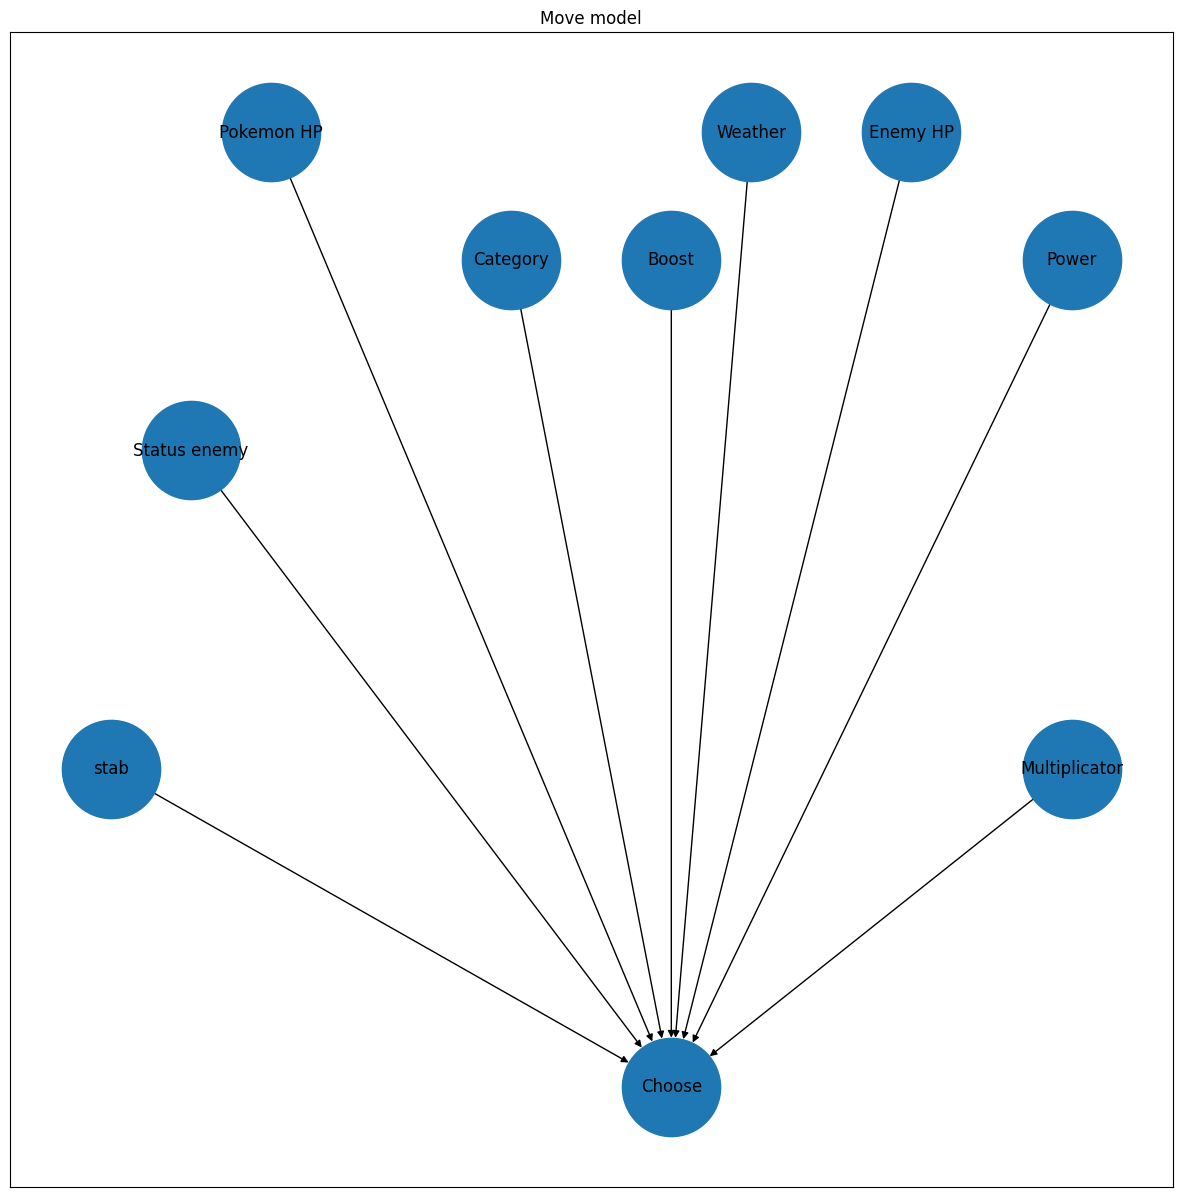

In [67]:
#we create the bayesian network
Move_model = BayesianNetwork([('Pokemon HP', 'Choose'), ('Enemy HP', 'Choose'), ('Status enemy', 'Choose'),
                              ('stab', 'Choose'), ('Multiplicator', 'Choose'), ('Power', 'Choose'),
                               ("Weather","Choose"), ("Category","Choose"), ("Boost","Choose"),
                                    ])
#we give to every node a position
position = {'Pokemon HP': [0.5, 0], 'Enemy HP': [1.3, 0],
       "stab": [0.3, -1.], 'Multiplicator': [1.5, -1],
       'Power': [1.5, -0.2], "Weather" : [1.1, 0],
       'Choose': [1, -1.5],"Category" : [0.8, -0.2], "Boost": [1,-0.2],"Status enemy" : [0.4, -0.5],
       }

#and we plot the network
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(Move_model, pos=position, ax=ax, node_size=5000)
ax.set_title('Move model')
fig.savefig('Move_bn')

In [28]:

#we use the Bayesian Estimator to calculate the parameter of the bayesian Network
estimator = BayesianEstimator(model=Move_model, data=df)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in Move_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                        prior_type="BDeu", 
                                        equivalent_sample_size=3500))
    
#then we add the CPDs to the model
Move_model.add_cpds(*CPDs)

#we check the model
print('Checking the model...')
print(f'The model is {Move_model.check_model()}\n\n')

#and we see the parameter for every node
for cpd in [cpd for cpd in Move_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)
    

Checking the model...
The model is True


CPD for Pokemon HP:
+---------------+-----------+
| Pokemon HP(0) | 0.0743339 |
+---------------+-----------+
| Pokemon HP(1) | 0.0918734 |
+---------------+-----------+
| Pokemon HP(2) | 0.101979  |
+---------------+-----------+
| Pokemon HP(3) | 0.138478  |
+---------------+-----------+
| Pokemon HP(4) | 0.593335  |
+---------------+-----------+
CPD for Choose:
+---------------+-----+--------------------+
| Boost         | ... | Boost(2)           |
+---------------+-----+--------------------+
| Category      | ... | Category(status)   |
+---------------+-----+--------------------+
| Enemy HP      | ... | Enemy HP(4)        |
+---------------+-----+--------------------+
| Multiplicator | ... | Multiplicator(4.0) |
+---------------+-----+--------------------+
| Pokemon HP    | ... | Pokemon HP(4)      |
+---------------+-----+--------------------+
| Power         | ... | Power(4)           |
+---------------+-----+--------------------+
| Statu

In [48]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle

EVIDENCE = {'Power': 2, #this means that is a move of medium power 
            'Multiplicator': 1, #the move has no advantage nor disadvantage against the enemy
            'stab': True, #the move has the same type of the Pokèmon so the damage is double
            'Enemy HP': 1, #the enemy has low life
            "Pokemon HP": 4, #the Pokèmon has full life
            "Category": "physical", #the move does damage
            "Weather": "none", #there is no weather condition
            "Status enemy": "normal", #The enemy has no alteration of his status
            "Boost":1 #the Pokèmon has a some boost to its statistics
            }

#We choose as inference model the VariableElimination one
inference = VariableElimination(Move_model)

prob = inference.query(["Choose"],EVIDENCE,
                          show_progress=True)
print(prob)

+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.0026 |
+-------------+---------------+
| Choose(1.0) |        0.9974 |
+-------------+---------------+


In [50]:
#we load the dataset for the switch 
df_switch = pd.read_csv("../parsing Dataset/log/Dataset-Switch.csv")

def Generate_Multiplicator_In_switch(x):
    EnemyType = x["Enemy Type"]
    InType = x["Pokemon In Type"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    InType = InType.split(",")

    for i in range(max(len(EnemyType), len(InType))):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
            InType[i] = InType[i][2:-1]
        elif i == 1:
            if len(EnemyType) > 1:
                EnemyType[1] = EnemyType[1][2:-2]
            if len(InType) > 1:
                InType[1] = InType[1][2:-2]
    for En_Type in EnemyType:
        if not En_Type.isalnum():
            continue
        for In_Type in InType:
            if not In_Type.isalnum():
                continue
            weakness = weakness * weak[In_Type][En_Type] 
    return weakness

def Generate_Multiplicator_Out_switch(x):
    EnemyType = x["Enemy Type"]
    OutType = x["Pokemon Out Type"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    OutType = OutType.split(",")

    for i in range(max(len(EnemyType), len(OutType))):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
            OutType[i] = OutType[i][2:-1]
        elif i == 1:
            if len(EnemyType) > 1:
                EnemyType[1] = EnemyType[1][2:-2]
            if len(OutType) > 1:
                OutType[1] = OutType[1][2:-2]
    for En_Type in EnemyType:
        if not En_Type.isalnum():
            continue
        for Out_Type in OutType:
            if not Out_Type.isalnum():
                continue
            weakness = weakness * weak[Out_Type][En_Type] 
    return weakness


In [51]:
#we do the same preProcessing of the first dataset
df_switch["HPout"] = df_switch["HPout"].map(percentual_Transform)
df_switch["HPEnemy"] = df_switch["HPEnemy"].map(percentual_Transform)
df_switch["Weather"] = df_switch["Weather"].str.rstrip().str.lower()
df_switch["StatusP"] = df_switch["StatusP"].str.rstrip().str.lower()

df_switch.rename({"HPout": "Pokemon HP","HPEnemy": "Enemy HP","TypeEnemy" : "Enemy Type","TypeIN":"Pokemon In Type", "TypeOUT":"Pokemon Out Type", "StatusP":"Status Pokemon"}, axis=1, inplace=True)

#In this dataset we have the Multiplicator of the entering Pokèmon and of the outgoing one
df_switch["Multiplicator In"] = df_switch[["Enemy Type", "Pokemon In Type"]].apply(Generate_Multiplicator_In_switch, axis=1)
df_switch["Multiplicator Out"] = df_switch[["Enemy Type", "Pokemon Out Type"]].apply(Generate_Multiplicator_Out_switch, axis=1)

#then we drop the useless columns
df_switch = df_switch.drop(["Enemy Type", "Pokemon In Type", "Pokemon Out Type"], axis= 1)

df_switch

,Switch In,Switch out,enemy,Pokemon HP,Enemy HP,Status Pokemon,Weather,Switch,Multiplicator In,Multiplicator Out
0,Emboar,Hydreigon,Klinklang,100.000000,100.000000,normal,none,1.0,1.00,1.00
1,Lugia,Klinklang,Emboar,100.000000,100.000000,normal,none,1.0,4.00,1.00
2,Hydreigon,Emboar,Lugia,100.000000,100.000000,normal,none,1.0,2.00,0.25
3,Emboar,Hydreigon,Lugia,100.000000,100.000000,normal,none,1.0,0.25,2.00
4,Hydreigon,Emboar,Lugia,61.963190,100.000000,normal,none,1.0,2.00,0.25
...,...,...,...,...,...,...,...,...,...,...
5809,Fezandipiti,Gyarados,Chansey,100.000000,100.000000,normal,none,1.0,1.00,1.00
5810,Entei,Chansey,Fezandipiti,100.000000,38.545455,psn,none,1.0,1.00,1.00
5811,Rotom,Chansey,Fezandipiti,100.000000,38.545455,psn,none,0.0,1.00,1.00
5812,Persian,Fezandipiti,Entei,38.545455,72.638436,par,none,1.0,1.00,1.00


In [52]:

#we reduce the number of value for the HP
enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='uniform')
enc.fit(df_switch[["Pokemon HP"]])
df_switch["Pokemon HP"] = enc.transform(df_switch[["Pokemon HP"]]).astype(int)

enc = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='uniform')
enc.fit(df_switch[["Enemy HP"]])
df_switch["Enemy HP"] = enc.transform(df_switch[["Enemy HP"]]).astype(int)

df_switch

,Switch In,Switch out,enemy,Pokemon HP,Enemy HP,Status Pokemon,Weather,Switch,Multiplicator In,Multiplicator Out
0,Emboar,Hydreigon,Klinklang,4,4,normal,none,1.0,1.00,1.00
1,Lugia,Klinklang,Emboar,4,4,normal,none,1.0,4.00,1.00
2,Hydreigon,Emboar,Lugia,4,4,normal,none,1.0,2.00,0.25
3,Emboar,Hydreigon,Lugia,4,4,normal,none,1.0,0.25,2.00
4,Hydreigon,Emboar,Lugia,3,4,normal,none,1.0,2.00,0.25
...,...,...,...,...,...,...,...,...,...,...
5809,Fezandipiti,Gyarados,Chansey,4,4,normal,none,1.0,1.00,1.00
5810,Entei,Chansey,Fezandipiti,4,1,psn,none,1.0,1.00,1.00
5811,Rotom,Chansey,Fezandipiti,4,1,psn,none,0.0,1.00,1.00
5812,Persian,Fezandipiti,Entei,1,3,par,none,1.0,1.00,1.00


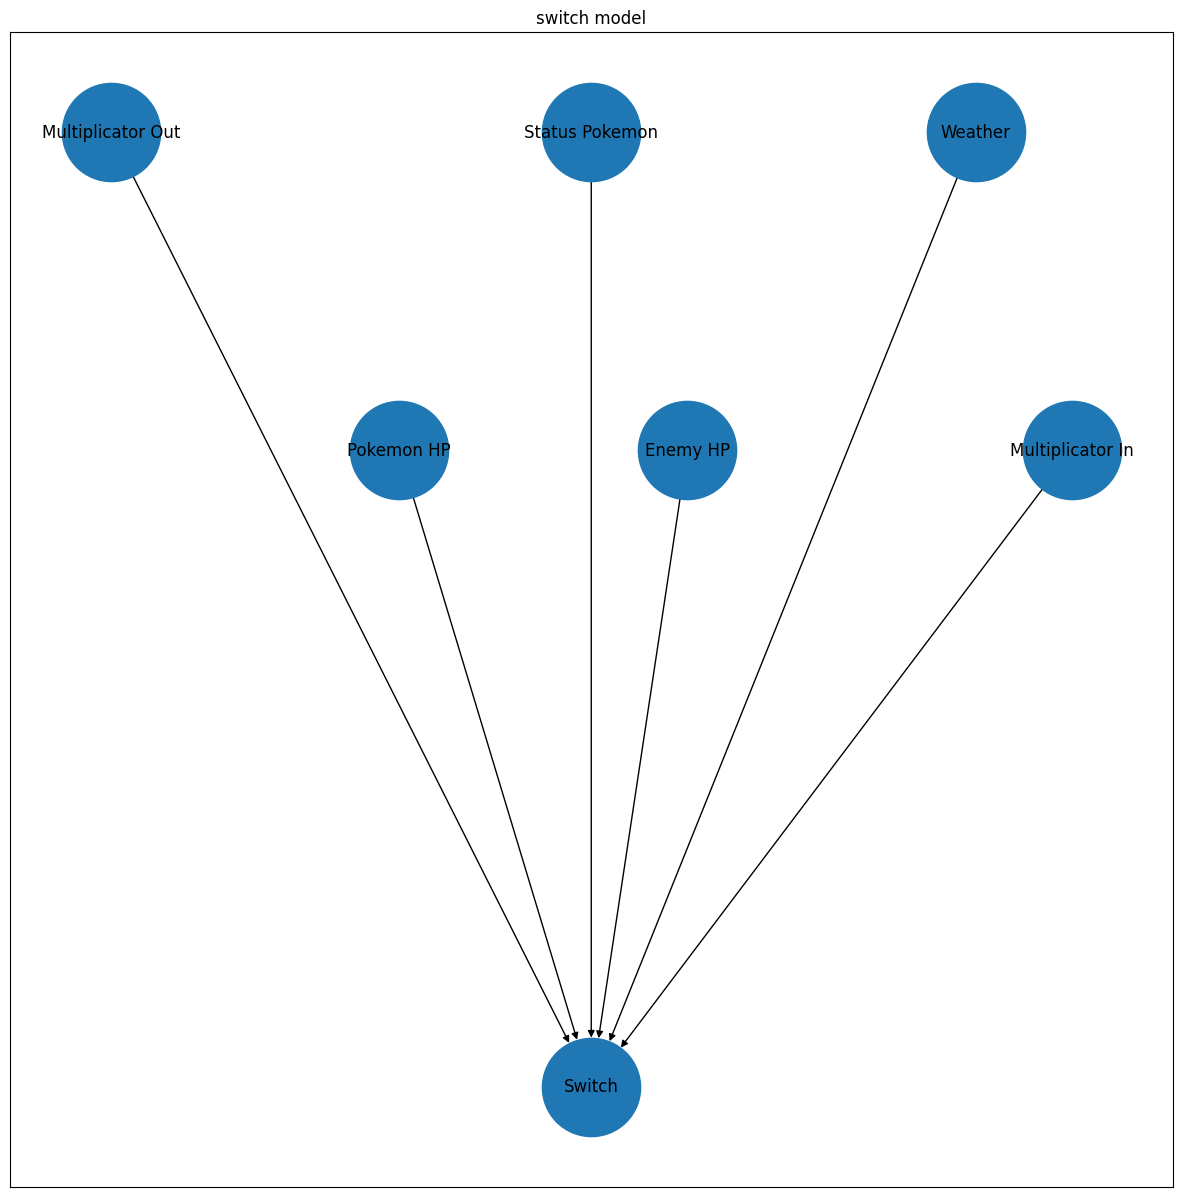

In [72]:
#as we did for the move we create the bayesian network
switch_model = BayesianNetwork([('Pokemon HP', 'Switch'), ('Enemy HP', 'Switch'), ('Status Pokemon', 'Switch'), ('Weather', 'Switch'), ('Multiplicator In', 'Switch'), ('Multiplicator Out', 'Switch')])

position = {'Pokemon HP': [0.9, 0], 'Enemy HP': [1.05, 0],
       "Multiplicator Out": [0.75, 0.15], 'Multiplicator In': [1.25, 0],
       'Switch': [1, -0.3], 'Status Pokemon' : [ 1,0.15], 'Weather' : [1.2, 0.15]}

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
nx.draw_networkx(switch_model, pos=position, ax=ax, node_size=5000)
ax.set_title('switch model')
fig.savefig('switch_bn')

In [73]:
#we estimate the parameter using the Bayesian Estimator
estimator = BayesianEstimator(model=switch_model, data=df_switch)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in switch_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=3500))
switch_model.add_cpds(*CPDs)

print('Checking the model...')
print(f'The model is {switch_model.check_model()}\n\n')

for cpd in [cpd for cpd in switch_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Pokemon HP:
+---------------+-----------+
| Pokemon HP(0) | 0.0912605 |
+---------------+-----------+
| Pokemon HP(1) | 0.100387  |
+---------------+-----------+
| Pokemon HP(2) | 0.11574   |
+---------------+-----------+
| Pokemon HP(3) | 0.139897  |
+---------------+-----------+
| Pokemon HP(4) | 0.552716  |
+---------------+-----------+
CPD for Switch:
+-------------------+-----+------------------------+
| Enemy HP          | ... | Enemy HP(4)            |
+-------------------+-----+------------------------+
| Multiplicator In  | ... | Multiplicator In(16.0) |
+-------------------+-----+------------------------+
| Multiplicator Out | ... | Multiplicator Out(8.0) |
+-------------------+-----+------------------------+
| Pokemon HP        | ... | Pokemon HP(4)          |
+-------------------+-----+------------------------+
| Status Pokemon    | ... | Status Pokemon(tox)    |
+-------------------+-----+------------------------+
| Weather

In [82]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle


EVIDENCE = {'Multiplicator In': 4, #the entering Pokèmon would have an advantage of 4
            'Multiplicator Out': 1, #the outgoing Pokèmon doesn't have any advantage
            'Enemy HP': 1, #the enemy has low health
            "Pokemon HP": 4, #the outgoing Pokèmon has full health
            "Status Pokemon": "normal", #the outgoing Pokèmon has no alteration
            "Weather": "none",} #The weather is normal

inference = VariableElimination(switch_model)

prob = inference.query(["Switch"],EVIDENCE,show_progress=False)
               
print(prob)


+-------------+---------------+
| Switch      |   phi(Switch) |
+=============+===============+
| Switch(0.0) |        0.0154 |
+-------------+---------------+
| Switch(1.0) |        0.9846 |
+-------------+---------------+


In [83]:
#after some test we decide to reduce the dimension of the network to see if it could improve its predicting accuracy

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df[["Pokemon HP"]])
df["Pokemon HP"] = enc.transform(df[["Pokemon HP"]]).astype(int)

enc.fit(df[["Enemy HP"]])
df["Enemy HP"] = enc.transform(df[["Enemy HP"]]).astype(int)

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df[["Power"]])
df["Power"] = enc.transform(df[["Power"]]).astype(int)

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df[["Boost"]])
df["Boost"] = enc.transform(df[["Boost"]]).astype(int)

df

,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Status enemy,Choose,Multiplicator,stab,Boost
0,klinklang,klinklang,Substitute,0,2,2,none,status,normal,1.0,1.0,False,1
1,hydreigon,klinklang,U-turn,0,2,2,none,physical,normal,1.0,1.0,False,1
2,klinklang,emboar,Return,1,2,2,none,physical,normal,1.0,1.0,False,1
3,klinklang,emboar,Substitute,0,2,2,none,status,normal,0.0,1.0,False,1
4,emboar,klinklang,Fire Blast,1,2,2,none,special,normal,1.0,1.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,persian,persian,Nasty Plot,0,2,2,none,status,par,1.0,1.0,False,1
8469,entei,persian,Sacred Fire,1,1,2,none,physical,par,1.0,1.0,True,1
8470,persian,entei,Dark Pulse,0,2,2,none,special,psn,1.0,1.0,False,1
8471,persian,entei,Nasty Plot,0,2,2,none,status,psn,0.0,1.0,False,1


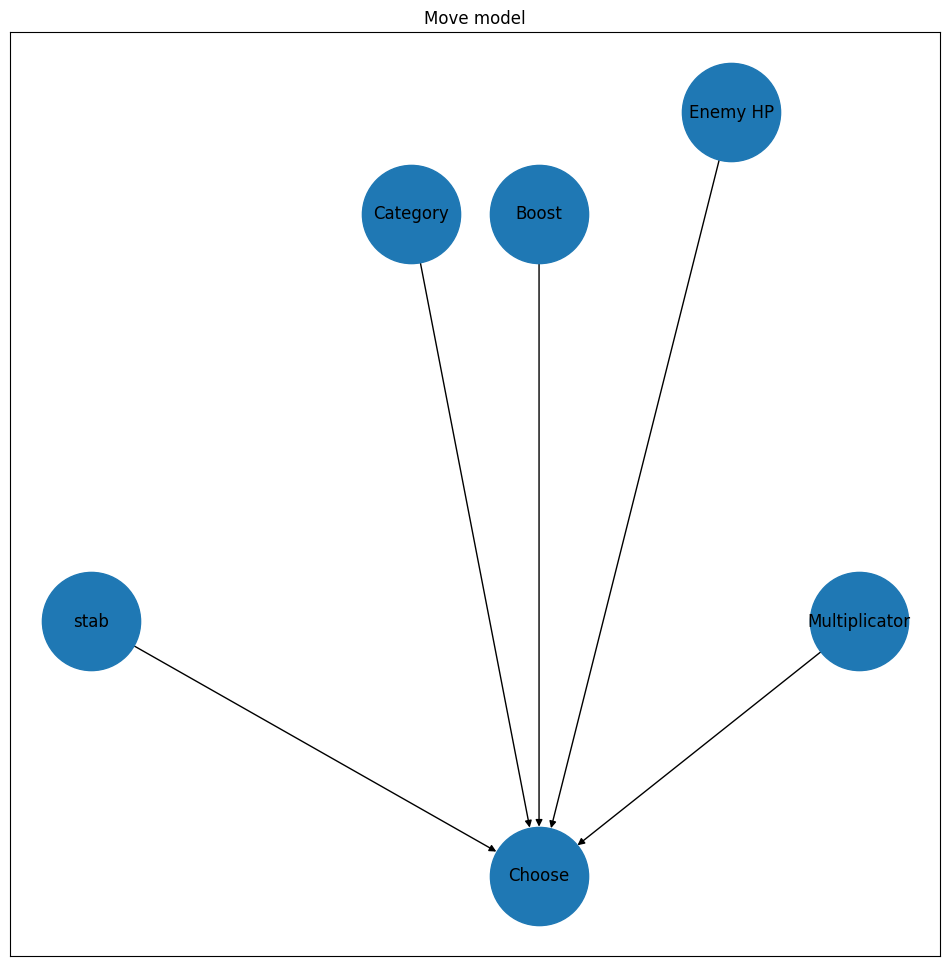

In [85]:
#in this new model we removed the less important node and reduced the number of different value for the remaining
Move_model = BayesianNetwork([('Enemy HP', 'Choose'),('stab', 'Choose'), ('Multiplicator', 'Choose'), 
                                ("Category","Choose"), ("Boost","Choose"),
                                    ])
pos = {'Enemy HP': [1.3, 0],
       "stab": [0.3, -1.], 'Multiplicator': [1.5, -1], 
       'Choose': [1, -1.5],"Category" : [0.8, -0.2], "Boost": [1,-0.2],
       }
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(Move_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Move model')
fig.savefig('Move_bn')

In [86]:

#we use the Bayesian Estimator to calculate the parameter of the bayesian Network
estimator = BayesianEstimator(model=Move_model, data=df)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in Move_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                        prior_type="BDeu", 
                                        equivalent_sample_size=3500))
    
#then we add the CPDs to the model
Move_model.add_cpds(*CPDs)

#we check the model
print('Checking the model...')
print(f'The model is {Move_model.check_model()}\n\n')

#and we see the parameter for every node
for cpd in [cpd for cpd in Move_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Enemy HP:
+-------------+----------+
| Enemy HP(0) | 0.132938 |
+-------------+----------+
| Enemy HP(1) | 0.143545 |
+-------------+----------+
| Enemy HP(2) | 0.723517 |
+-------------+----------+
CPD for Choose:
+---------------+-----+--------------------+
| Boost         | ... | Boost(2)           |
+---------------+-----+--------------------+
| Category      | ... | Category(status)   |
+---------------+-----+--------------------+
| Enemy HP      | ... | Enemy HP(2)        |
+---------------+-----+--------------------+
| Multiplicator | ... | Multiplicator(4.0) |
+---------------+-----+--------------------+
| stab          | ... | stab(True)         |
+---------------+-----+--------------------+
| Choose(0.0)   | ... | 0.5                |
+---------------+-----+--------------------+
| Choose(1.0)   | ... | 0.5                |
+---------------+-----+--------------------+
CPD for stab:
+-------------+--------+
| stab(False) | 0.489

In [88]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle

EVIDENCE = {'Multiplicator': 1, #the move has no advantage nor disadvantage against the enemy
            'stab': True, #the move has the same type of the Pokèmon so the damage is double
            'Enemy HP': 1, #the enemy has low life
            "Category": "physical", #the move does damage
            "Boost":1 #the Pokèmon has a some boost to its statistics
            }

#We choose as inference model the VariableElimination one
inference = VariableElimination(Move_model)

prob = inference.query(["Choose"],EVIDENCE,
                          show_progress=True)
print(prob)

+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.3291 |
+-------------+---------------+
| Choose(1.0) |        0.6709 |
+-------------+---------------+


In [89]:

enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df_switch[["Pokemon HP"]])
df_switch["Pokemon HP"] = enc.transform(df_switch[["Pokemon HP"]]).astype(int)
enc = KBinsDiscretizer(n_bins=3, encode='ordinal',strategy='kmeans')
enc.fit(df_switch[["Enemy HP"]])
df_switch["Enemy HP"] = enc.transform(df_switch[["Enemy HP"]]).astype(int)
df_switch

,Switch In,Switch out,enemy,Pokemon HP,Enemy HP,Status Pokemon,Weather,Switch,Multiplicator In,Multiplicator Out
0,Emboar,Hydreigon,Klinklang,2,2,normal,none,1.0,1.00,1.00
1,Lugia,Klinklang,Emboar,2,2,normal,none,1.0,4.00,1.00
2,Hydreigon,Emboar,Lugia,2,2,normal,none,1.0,2.00,0.25
3,Emboar,Hydreigon,Lugia,2,2,normal,none,1.0,0.25,2.00
4,Hydreigon,Emboar,Lugia,2,2,normal,none,1.0,2.00,0.25
...,...,...,...,...,...,...,...,...,...,...
5809,Fezandipiti,Gyarados,Chansey,2,2,normal,none,1.0,1.00,1.00
5810,Entei,Chansey,Fezandipiti,2,0,psn,none,1.0,1.00,1.00
5811,Rotom,Chansey,Fezandipiti,2,0,psn,none,0.0,1.00,1.00
5812,Persian,Fezandipiti,Entei,0,2,par,none,1.0,1.00,1.00


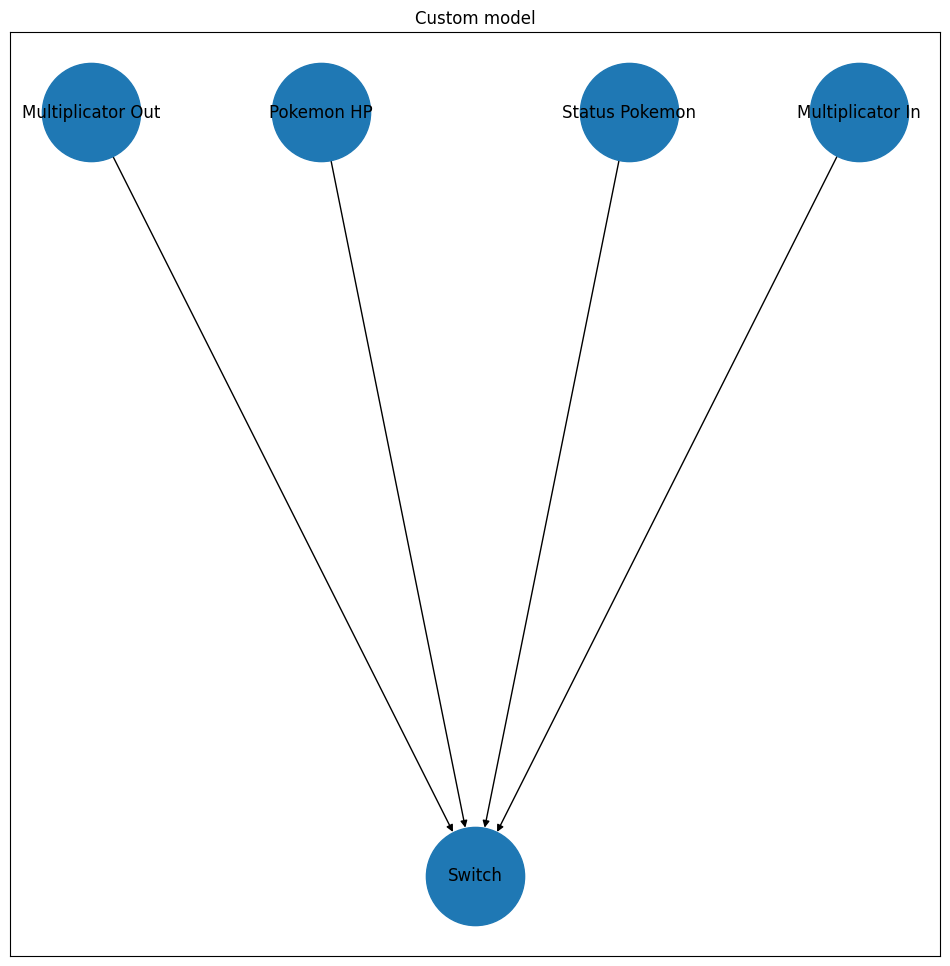

In [100]:
switch_model = BayesianNetwork([('Pokemon HP', 'Switch'), 
                                 ('Status Pokemon', 'Switch'), 
                                 ('Multiplicator In', 'Switch'), ('Multiplicator Out', 'Switch')])
pos = {'Pokemon HP': [0.9, 0],
       "Multiplicator Out": [0.75, 0], 'Multiplicator In': [1.25, 0],
       'Switch': [1, -0.1], 'Status Pokemon' : [1.1, 0]}
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(switch_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')

In [101]:
#we estimate the parameter using the Bayesian Estimator
estimator = BayesianEstimator(model=switch_model, data=df_switch)

CPDs = []
#for every node we estimate the parameter and add them to the list
for node in switch_model.nodes():
    CPDs.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=3500))
switch_model.add_cpds(*CPDs)

print('Checking the model...')
print(f'The model is {switch_model.check_model()}\n\n')

for cpd in [cpd for cpd in switch_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)

Checking the model...
The model is True


CPD for Pokemon HP:
+---------------+----------+
| Pokemon HP(0) | 0.166595 |
+---------------+----------+
| Pokemon HP(1) | 0.165844 |
+---------------+----------+
| Pokemon HP(2) | 0.667561 |
+---------------+----------+
CPD for Switch:
+-------------------+-----+------------------------+
| Multiplicator In  | ... | Multiplicator In(16.0) |
+-------------------+-----+------------------------+
| Multiplicator Out | ... | Multiplicator Out(8.0) |
+-------------------+-----+------------------------+
| Pokemon HP        | ... | Pokemon HP(2)          |
+-------------------+-----+------------------------+
| Status Pokemon    | ... | Status Pokemon(tox)    |
+-------------------+-----+------------------------+
| Switch(0.0)       | ... | 0.5                    |
+-------------------+-----+------------------------+
| Switch(1.0)       | ... | 0.5                    |
+-------------------+-----+------------------------+
CPD for Status Pokemon:
+-----

In [102]:
#we do a little test of the network, with an example of a situation in a battle

#this evidence is of a single move during a turn of a battle


EVIDENCE = {'Multiplicator In': 4, #the entering Pokèmon would have an advantage of 4
            'Multiplicator Out': 1, #the outgoing Pokèmon doesn't have any advantage
            "Pokemon HP": 2, #the outgoing Pokèmon has full health
            "Status Pokemon": "normal", #the outgoing Pokèmon has no alteration
            } 

inference = VariableElimination(switch_model)

prob = inference.query(["Switch"],EVIDENCE,show_progress=False)
               
print(prob)

+-------------+---------------+
| Switch      |   phi(Switch) |
+=============+===============+
| Switch(0.0) |        0.3818 |
+-------------+---------------+
| Switch(1.0) |        0.6182 |
+-------------+---------------+
